## Analysis and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

import warnings as w
w.filterwarnings('ignore')

In [2]:
data = pd.read_csv('users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


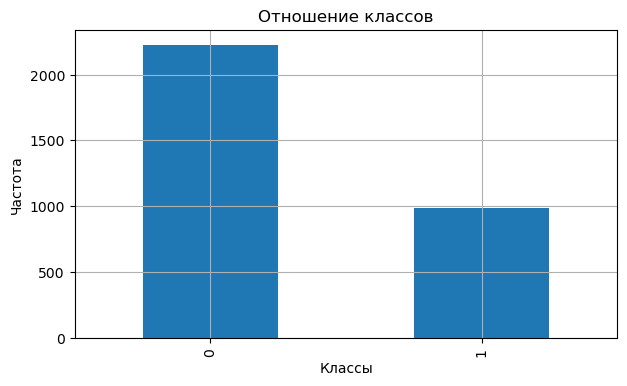

In [4]:
data['is_ultra'].value_counts().plot(kind='bar', 
                                     grid=True,
                                     figsize=(7, 4),
                                     title='Отношение классов',
                                     xlabel='Классы',
                                     ylabel='Частота');

**Сбалансируем классы с помощью upsample**

In [5]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    return shuffle(features_upsampled, target_upsampled, random_state=1)

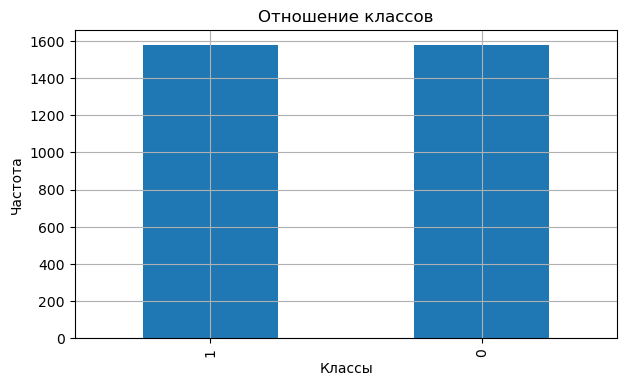

In [6]:
X = data.drop('is_ultra', axis=1)
y = data['is_ultra']

numeric = []
[numeric.append(i) for i in data.columns if data[i].dtype == float or data[i].dtype == int]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric])
X_valid_scaled = scaler.transform(X_valid[numeric])
X_test_scaled = scaler.transform(X_test[numeric])

ros = RandomOverSampler(random_state=1)
X_train_up, y_train_up = ros.fit_resample(X_train_scaled, y_train)
y_train_up.value_counts().plot(kind='bar', 
                               grid=True, 
                               figsize=(7, 4),
                               title='Отношение классов',
                               xlabel='Классы',
                               ylabel='Частота');

## RandomForestClassifier

In [7]:
%%time
model = RandomForestClassifier(random_state=1)
rfc_params = {'max_depth': range(2, 6),
              'n_estimators': range(12),
              'criterion': ['gini', 'entropy'],
              'min_samples_split': range(4),
              'min_samples_leaf': range(4)}
rfc_model = GridSearchCV(model, 
                         rfc_params, 
                         scoring='accuracy', 
                         cv=5).fit(X_train_up, y_train_up)
rfc_valid = accuracy_score(y_valid, rfc_model.predict(X_valid_scaled))
rfc_best_score = rfc_model.best_score_
rfc_best_params = rfc_model.best_params_
print('Accuracy valid', rfc_valid, 'Accuracy train', rfc_best_score, 'Best params', rfc_best_params, sep='\n\n')

Accuracy valid

0.8215767634854771

Accuracy train

0.7578973943647889

Best params

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 6}
CPU times: total: 2min 45s
Wall time: 2min 50s


## KNeighborsClassifier

In [8]:
%%time
model = KNeighborsClassifier()
knc_params = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
knc_model = GridSearchCV(model, 
                         knc_params, 
                         scoring='accuracy', 
                         cv=5).fit(X_train_up, y_train_up)
knc_valid = accuracy_score(y_valid, knc_model.predict(X_valid_scaled))
knc_best_score = knc_model.best_score_
knc_best_params = knc_model.best_params_
print('Accuracy valid', knc_valid, 'Accuracy train', knc_best_score, 'Best params', knc_best_params, sep='\n\n')

Accuracy valid

0.7531120331950207

Accuracy train

0.8659972603835463

Best params

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
CPU times: total: 3.67 s
Wall time: 3.67 s


## XGBClassifier

In [9]:
%%time
model = XGBClassifier(random_state=1)
xgb_params = {'max_depth': range(2, 10),
              'learning_rate': [0.05,0.1],
              'n_estimators': range(10, 101, 10)}
xgb_model = GridSearchCV(model, 
                         xgb_params, 
                         scoring='accuracy', 
                         cv=5).fit(X_train_up, y_train_up)
xgb_valid = accuracy_score(y_valid, xgb_model.predict(X_valid_scaled))
xgb_best_score = xgb_model.best_score_
xgb_best_params = xgb_model.best_params_
print('Accuracy valid', xgb_valid, 'Accuracy train', xgb_best_score, 'Best params', xgb_best_params, sep='\n\n')

Accuracy valid

0.7925311203319502

Accuracy train

0.8596726458295839

Best params

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
CPU times: total: 6min 6s
Wall time: 2min 19s


## Overall result and test

In [10]:
objects = [[rfc_best_score, rfc_valid],
           [knc_best_score, knc_valid],
           [xgb_best_score, xgb_valid]]
columns = ['train', 'valid']
overall = pd.DataFrame(data=objects,
                       columns=columns,
                       index=['RFC', 'KNC', 'XGB'])
overall.sort_values(by='valid', ascending=False)

,train,valid
RFC,0.757897,0.821577
XGB,0.859673,0.792531
KNC,0.865997,0.753112


In [11]:
rfc_test = accuracy_score(y_test, rfc_model.predict(X_test_scaled))
print('Accuracy test', rfc_test)

Accuracy test 0.782608695652174


На тестовой выборке была проверена модель с наибольшим значением метрики accuracy на валидационной выборке

Вывод:
1. Наивысшее значение метрики accuracy имеет модель KNeighborsClassifier, но модель переобучается
2. Модель RandomForestClassifier показала улучшение на валидационной и тестовой выборках относительно обучающей
3. Инструмент RandomOverSampler помог избежать дисбаланса классов
4. Учитывая размер датасета получены максимальные значения метрики accuracy